In [15]:
import arbor as A
import matplotlib.pyplot as plt

# Setup the Parameters

In [2]:
ncells = 4
T = 150

# Configure the Simulation

With the same setup ($N$ neurons in a ring), we switch from NEST to Arbor.

In [117]:
class ring(A.recipe):

    def __init__(self, ncells):
        A.recipe.__init__(self) # NEVER forget this!
        self.ncells = ncells
        self.weight = 300
        self.delay  = 5    # ms
        self.t_inj  = [10, 30, 50, 80, 120] # ms

    def num_cells(self):
        return self.ncells

    def cell_description(self, gid):
        # NOTE: We ignore the gid argument here since all cells are LIF
        # but in general we dispatch on gid to return different objects.
        cell = A.lif_cell("out", "in")
        cell.C_m = 15.0     # pF
        cell.tau_m = 25.58  # ms
        cell.t_ref = 2.0    # ms
        cell.E_L = -65.0    # mV
        cell.V_th = -40.0   # mV
        cell.E_R = -75.0    # mV
        cell.V_m = -50      # mV
        return cell

    def cell_kind(self, gid):
        return A.cell_kind.lif

    def connections_on(self, gid):
        src = (gid - 1) % self.ncells
        return [A.connection((src, "out"), "in", self.weight, self.delay)]

    def event_generators(self, gid):
        if gid == 0:
            sched = A.explicit_schedule(self.t_inj)
            return [A.event_generator("in", self.weight, sched)]
        return []

    def probes(self, gid):
        return [A.lif_probe_voltage()]

## Recipe? What? Why?

Arbor uses a bundle of lazy callbacks to configure a simulation, called a *recipe*.
If this choice seems weird: It's for making large simulation on a demand-driven, local-only basis.
Also, only the minimum information is provided at each point, eg kind and description of cells.

A few important things:
- `cell_description` and `cell_kind` need to work together.
- The network is configured from the standpoint of the *receiver*.
- Configuring a probe does not immediately perform measurements.

Also, this example has a few steps that'll make more sense in a larger context. Example turning `recipes`
into `simulation`s requires an extra step, but in general we provide a hardware description and a load
balancer.

# Turn the Recipe into an Executable Object

Make a concrete instance of the recipe, then build a simulation from it.
Then configure data extraction:
- Record all spikes
- Attach a sampler to each probe on a regular time grid

In [118]:
rec = ring(ncells)
sim = A.simulation(rec)
sim.record(A.spike_recording.all)
# This API is a bit weird and will soon improve!
hdl = [sim.sample((gid, 0), A.regular_schedule(0.1)) for gid in range(ncells)]

# Run it!

In [119]:
sim.run(150)

150.0

# Inspect Spikes

In [129]:
print("Spikes:")

spikes = [[] for _ in range(ncells)]

for (gid, lid), t in sim.spikes():
    print(f" ^ {t:9.2f}ms cell={gid} detector={lid}")
    spikes[gid].append(t)

Spikes:
 ^     10.00ms cell=0 detector=0
 ^     15.00ms cell=1 detector=0
 ^     20.00ms cell=2 detector=0
 ^     25.00ms cell=3 detector=0
 ^     30.00ms cell=0 detector=0
 ^    120.00ms cell=0 detector=0


# Huge Success

(0.0, 150.0)

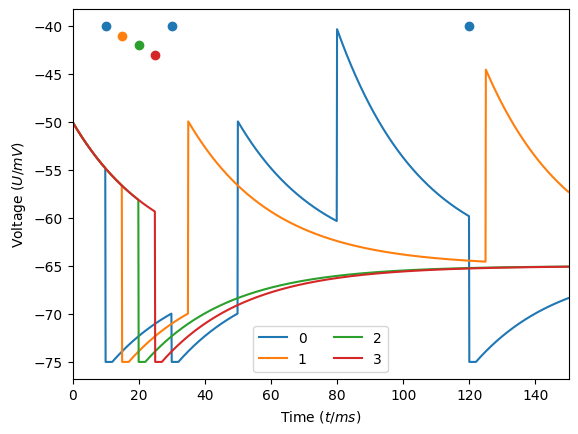

In [128]:
fg, ax = plt.subplots()

for gid, h in enumerate(hdl):
    for data, meta in sim.samples(h):
        ax.plot(data[:, 0], data[:, 1], label=f"{gid}")
        
for gid, sps in enumerate(spikes):
    ax.scatter(sps, [-1*gid - 40 for _ in sps])
        
ax.legend(loc='lower center', ncol=2)
ax.set_xlabel('Time ($t/ms$)')
ax.set_ylabel('Voltage ($U/mV$)')
ax.set_xlim((0, T))

# Discussion

We never observe the spike potential, this is a consequence of the integration scheme which puts sampling after the full step.
Spike timings are marked on the graph above to prove their existence.

The `simulation` object encapsulates the full simulation; Arbor has no internal state. Thus, we could make more of them and
run each independently. Also, between two calls to run, we can reconfigure the connections (plasticity?).

# Task (10min)

Try to run this on your own and play a bit. You can try to 
- time NEST and Arbor
- add more cells
- tweak parameters
- vary parameters per gid
- ...